In [1]:
import numpy as np
from orphics import maps, cosmology,io,stats
import matplotlib.pyplot as plt

from scipy import optimize
import cosmo_cleaner
from cosmo_cleaner import fisher as fisher,plot
import camb
from cosmo_cleaner import cosmology
from cosmo_cleaner import triangle_plot
def get_corr(cross,f1,f2):
    return np.sqrt(cross**2/(f1*f2))
def get_der(spectra,pars,cleaned=False):
    """derivative function used for fisher"""
    der_spectra_alpha = np.ones((len(list(spectra.items())[0][1]), len(spectra), len(pars)))
    for i in range(len(pars)):
        print(f"Taking field derivatives wrt {pars[i]}")
        der=cosmology.derivative_parameter(ells,1,0.5,defaultCosmology,pars[i],delta=0.00005)
        der_spectra_alpha[:, 0, i] = der[1][:cut]
        der_spectra_alpha[:, 1, i] = der[0][:cut]
        if cleaned==True:
            der_spectra_alpha[:, 2, i] = der[-1][:cut]
        else:
            der_spectra_alpha[:, 2, i] = der[2][:cut]
    return der_spectra_alpha


Cleaning the high redshift portion of the lensing field

In [5]:
defaultCosmology = {'omch2': 0.1198
                    ,'ombh2': 0.02225
                    ,'H0': 67.3
                    ,'ns': 0.9645
                    ,'As': 2.2e-9
                    ,'mnu': 0.06
                    ,'w0': -1.0
                    ,'tau':0.06
                    ,'nnu':3.046
                    ,'wa': 0.,'bias':2,'A_l':1.2}


nz = 1000
kmax = 10
zmin = 0.
ells=np.arange(2000)

pars = camb.CAMBparams()
pars.set_dark_energy(w=defaultCosmology['w0'],wa = defaultCosmology['wa'], dark_energy_model = 'ppf')
pars.set_cosmology(H0=defaultCosmology['H0'], cosmomc_theta = None,ombh2=defaultCosmology['ombh2'], 
               omch2=defaultCosmology['omch2'], mnu=defaultCosmology['mnu'], tau = defaultCosmology['tau'],
               nnu = defaultCosmology['nnu'], num_massive_neutrinos = 3)
#pars.NonLinear = model.NonLinear_both
pars.InitPower.set_params(ns=defaultCosmology['ns'],As=defaultCosmology['As'])

results = camb.get_results(pars)

In [6]:
default=cosmology.cosmology(nz,kmax,zmin,ells,defaultCosmology,pars,results)

In [5]:
#load the idealised window functions

In [22]:
clgg,clkg,clkk,clcibcib,clcibk,cl_clean=default.get_fields(idealised=True)

In [23]:
g1=default.windows[0]
g2=default.windows[1]
g3=default.windows[2]

Text(0.5, 1.0, 'window function')

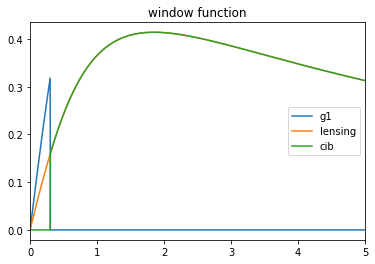

In [27]:
plt.plot(default.zs,g1,label='g1')
plt.plot(default.zs,g2,label='lensing')
plt.plot(default.zs,g3,label='cib')
plt.legend()
plt.xlim(0,5)
plt.title("window function")

Text(0.5, 1.0, 'correlation function')

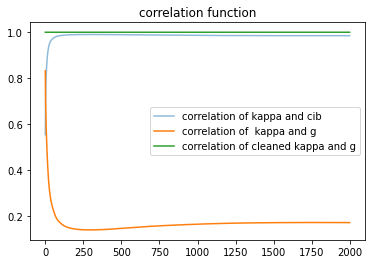

In [38]:
plt.plot(get_corr(clcibk,clcibcib,clkk),label='correlation of kappa and cib',alpha=0.5)
plt.plot(get_corr(clkg,clkk,clgg),label='correlation of  kappa and g')
plt.plot(get_corr(clkg,cl_clean,clgg),label='correlation of cleaned kappa and g')

plt.legend()
plt.title('correlation function')

Fisher constraint on the parameters

In [39]:
der=cosmology.derivative_parameter(ells,1,0.5,defaultCosmology,'bias',delta=0.00005)


In [40]:
base_error=[]
for i in range(500,501):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': clkk[:cut]}
    #der=cosmology.derivative_parameter(ells,1,0.5,defaultCosmology,'bias',delta=0.00005)
    der_spectra_alpha = np.ones((len(clkg[:cut]), len(spectra), 1))
    der_spectra_alpha[:, 0, 0] = der[0][:cut]
    der_spectra_alpha[:, 1, 0] = der[1][:cut]
    der_spectra_alpha[:, 2, 0] = der[2][:cut]
    a=fisher.Fisher(1,1,np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    a.get_fisher()[0]
    base_error.append(a.get_fisher()[0])

500


/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return 1/result
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:166: RuntimeWarning: divide by zero encountered in power
  self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)


Fisher matrix becomes singular upon cleaning.

In [45]:
improved_error=[]
for i in range(3,4):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': cl_clean[:cut]}
    der=cosmology.derivative_parameter(ells,1,0.5,defaultCosmology,'bias',delta=0.00005)
    der_spectra_alpha = np.ones((len(clkg[:cut]), len(spectra), 1))
    der_spectra_alpha[:, 0, 0] = der[0][:cut]
    der_spectra_alpha[:, 1, 0] = der[1][:cut]
    der_spectra_alpha[:, 2, 0] = der[-1][:cut]
    a=fisher.Fisher(1,1,np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    a.get_fisher()[0]
    improved_error.append(a.get_fisher()[0])

3


LinAlgError: Singular matrix

In [43]:
improved_error


[2.1227317550921614e-12]

## More realistic scenario

In [39]:
clgg,clkg,clkk,clcibcib,clcibk,cl_clean=default.get_fields(idealised=False)

Text(0.5, 1.0, 'window function')

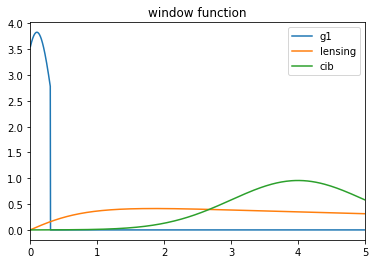

In [41]:
g1=default.windows[0]
g2=default.windows[1]
g3=default.windows[2]
plt.plot(default.zs,g1,label='g1')
plt.plot(default.zs,g2,label='lensing')
plt.plot(default.zs,g3,label='cib')
plt.legend()
plt.xlim(0,5)
plt.title("window function")

Text(0.5, 1.0, 'correlation function')

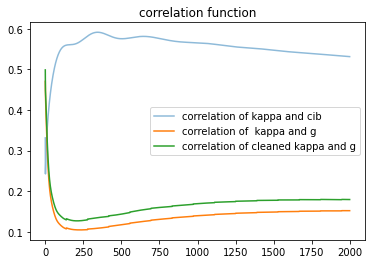

In [42]:
plt.plot(get_corr(clcibk,clcibcib,clkk),label='correlation of kappa and cib',alpha=0.5)
plt.plot(get_corr(clkg,clkk,clgg),label='correlation of  kappa and g')
plt.plot(get_corr(clkg,cl_clean,clgg),label='correlation of cleaned kappa and g')

plt.legend()
plt.title('correlation function')

In [45]:
#get_der(defaultCosmology,cut,spectra,pars,cleaned=False)

In [46]:
pars=['bias','A_l']
base_error=[]
fishermatrix=[]
for i in range(2,500,50):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': clkk[:cut]}
    der_spectra_alpha=get_der(spectra,pars,cleaned=False)
    a=fisher.Fisher(1,len(pars),np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    base_error.append(a.get_fisher()[0])
    fishermatrix.append(a.fisher)


2
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return 1/result
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:166: RuntimeWarning: divide by zero encountered in power
  self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:170: RuntimeWarning: invalid value encountered in sqrt
  self.error_marginalized = np.linalg.inv(self.fisher)**0.5


52
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
102
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
152
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
202
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
252
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
302
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
352
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
402
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
452
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


In [32]:
clean_error=[]
fishermatrix_clean=[]
for i in range(2,500,50):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': cl_clean[:cut]}
    der_spectra_alpha=get_der(spectra,pars,cleaned=True)
    a=fisher.Fisher(1,len(pars),np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    clean_error.append(a.get_fisher()[0])
    fishermatrix_clean.append(a.fisher)

2
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
52
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
102
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
152
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
202
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
252
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
302
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
352
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
402
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
452
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


In [88]:
clean_fisher=np.array([np.array([[1.12539924, 1.66666667],
        [1.66666667, 5.55555556]]),
 np.array([[1363.03132986, 2210.        ],
        [2210.        , 7366.66666665]]),
 np.array([[ 5232.75652848,  8585.        ],
        [ 8585.        , 28616.66666662]]),
 np.array([[11614.30205631, 19126.66666667],
        [19126.66666667, 63755.55555546]]),
 np.array([[ 20512.90028046,  33835.00000001],
        [ 33835.00000001, 112783.33333317]]),
 np.array([[ 31931.20913399,  52710.00000001],
        [ 52710.00000001, 175699.99999973]]),
 np.array([[ 45875.78623977,  75751.66666668],
        [ 75751.66666668, 252505.55555514]]),
 np.array([[ 62350.093252  , 102960.00000002],
        [102960.00000002, 343199.99999943]]),
 np.array([[ 81353.36560711, 134335.00000002],
        [134335.00000002, 447783.33333257]]),
 np.array([[102889.57658617, 169876.66666668],
        [169876.66666668, 566255.55555455]])])

base_error=[]
cleaned_error=[]

for i in range(len(clean_fisher)):
    error_non_marginalizedbase = np.diag(fishermatrix[i])**-0.5 
    error_non_marginalized = np.diag(clean_fisher[i])**-0.5 
    base_error.append(error_non_marginalizedbase[0])
    cleaned_error.append(error_non_marginalized[0])
cleaned_error=np.array(cleaned_error)
base_error=np.array(base_error)

In [49]:
covlist=[]
covclean=[]

base_error=[]
cleaned_error=[]
for i in range(len(clean_fisher)):
    cov=np.linalg.inv(fishermatrix[i])
    cov_clean=np.linalg.inv(clean_fisher[i])
    covlist.append(cov)
    covclean.append(cov_clean)
    error_non_marginalizedbase = np.diag(fishermatrix[i])**-0.5 
    error_non_marginalized = np.diag(clean_fisher[i])**-0.5 
    base_error.append(error_non_marginalizedbase[0])
    cleaned_error.append(error_non_marginalized[0])
cleaned_error=np.array(cleaned_error)
base_error=np.array(base_error)    

parameters=['bias', 'A_l']
fiducial=[2., 1.2]

In [51]:
ells=[]
for i in range(2,500,50):
    ells.append(i)

In [72]:
base_error

[1.2738131960733587,
 0.03797989259528041,
 0.019470185898863374,
 0.013086529568361423,
 0.009852436621011304,
 0.007899010678946845,
 0.006591197064531414,
 0.005654383586364403,
 0.00495040861563341,
 0.0044019714243782515]

In [73]:
cleaned_error

array([0.94264179, 0.02708614, 0.01382403, 0.00927905, 0.00698211,
       0.00559619, 0.00466883, 0.00400481, 0.003506  , 0.00311756])

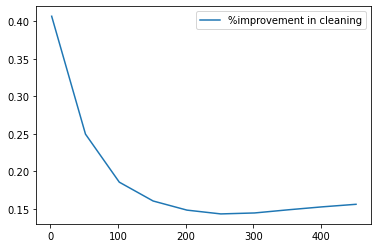

In [92]:
plt.plot(ells,100*(base_error-cleaned_error)/cleaned_error,label='%improvement in cleaning')
plt.legend()

generating new axis
['$\\mathrm{bias}$', '$\\mathrm{A\\_l}$']
['$\\mathrm{bias}$', '$\\mathrm{A\\_l}$']


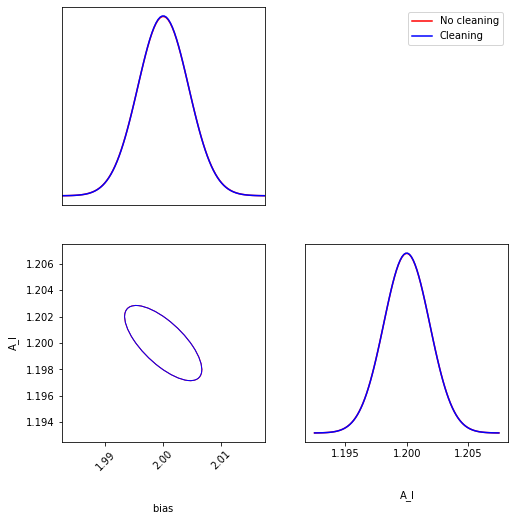

In [69]:
fig, axes = triangle_plot.plot_triangle_base(parameters,fiducial,covlist[-1] , one_sigma_only=True,color_1d='red',ellipse_kwargs1={'ls': '-', 'edgecolor': 'red'})
# now plot a slightly cleaned instrument
triangle_plot.plot_triangle_base(parameters,fiducial, covclean[-1], one_sigma_only=True,
                                  f=fig, ax=axes,
                                  ellipse_kwargs1={'ls': '-', 'edgecolor': 'blue'},
                                  ellipse_kwargs2={'ls': '-', 'edgecolor': 'blue'},
                                  color_1d='blue'
                                 );

l1, = axes[0, -1].plot([],[],'-',color="red", label='No cleaning')
l2, = axes[0, -1].plot([],[],'-',color="blue", label='Cleaning')
axes[0, -1].legend()

## More realistic case 2

In [12]:
clgg,clkg,clkk,clcibcib,clcibk,cl_clean=default.get_fields(idealised=False)

Text(0.5, 1.0, 'window function')

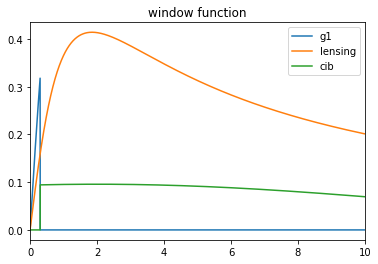

In [13]:
g1=default.windows[0]
g2=default.windows[1]
g3=default.windows[2]
plt.plot(default.zs,g1,label='g1')
plt.plot(default.zs,g2,label='lensing')
plt.plot(default.zs,g3,label='cib')
plt.legend()
plt.xlim(0,10)
plt.title("window function")

Text(0.5, 1.0, 'correlation function')

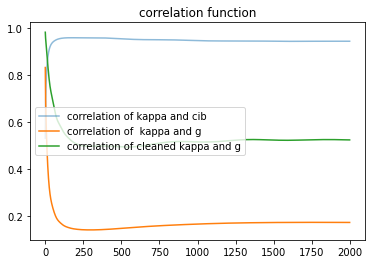

In [17]:
plt.plot(get_corr(clcibk,clcibcib,clkk),label='correlation of kappa and cib',alpha=0.5)
plt.plot(get_corr(clkg,clkk,clgg),label='correlation of  kappa and g')
plt.plot(get_corr(clkg,cl_clean,clgg),label='correlation of cleaned kappa and g')

plt.legend()
plt.title('correlation function')

In [18]:
base_error

[0.9484671755255907,
 0.019167283617154522,
 0.009771443680274768,
 0.006550805476806076,
 0.004924597733855675]

In [15]:
pars=['bias','A_l']
base_error=[]
fishermatrix=[]
for i in range(2,500,100):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': clkk[:cut]}
    der_spectra_alpha=get_der(spectra,pars,cleaned=False)
    a=fisher.Fisher(1,len(pars),np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    base_error.append(a.get_fisher()[0])
    fishermatrix.append(a.fisher)

2
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return 1/result
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:166: RuntimeWarning: divide by zero encountered in power
  self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:170: RuntimeWarning: invalid value encountered in sqrt
  self.error_marginalized = np.linalg.inv(self.fisher)**0.5


102
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
202
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
302
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
402
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


In [20]:
clean_error=[]
fishermatrix_clean=[]
for i in range(2,500,100):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': cl_clean[:cut]}
    der_spectra_alpha=get_der(spectra,pars,cleaned=True)
    a=fisher.Fisher(1,len(pars),np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    clean_error.append(a.get_fisher()[0])
    fishermatrix_clean.append(a.fisher)

2
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return 1/result
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:166: RuntimeWarning: divide by zero encountered in power
  self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:170: RuntimeWarning: invalid value encountered in sqrt
  self.error_marginalized = np.linalg.inv(self.fisher)**0.5


102
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
202
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
302
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
402
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


In [21]:
covlist=[]
covclean=[]

base_error=[]
cleaned_error=[]
for i in range(len(fishermatrix_clean)):
    cov=np.linalg.inv(fishermatrix[i])
    cov_clean=np.linalg.inv(fishermatrix_clean[i])
    covlist.append(cov)
    covclean.append(cov_clean)
    error_non_marginalizedbase = np.diag(fishermatrix[i])**-0.5 
    error_non_marginalized = np.diag(fishermatrix_clean[i])**-0.5 
    base_error.append(error_non_marginalizedbase[0])
    cleaned_error.append(error_non_marginalized[0])
cleaned_error=np.array(cleaned_error)
base_error=np.array(base_error)    

parameters=['bias', 'A_l']
fiducial=[2., 1.2]

generating new axis
['$\\mathrm{bias}$', '$\\mathrm{A\\_l}$']
['$\\mathrm{bias}$', '$\\mathrm{A\\_l}$']


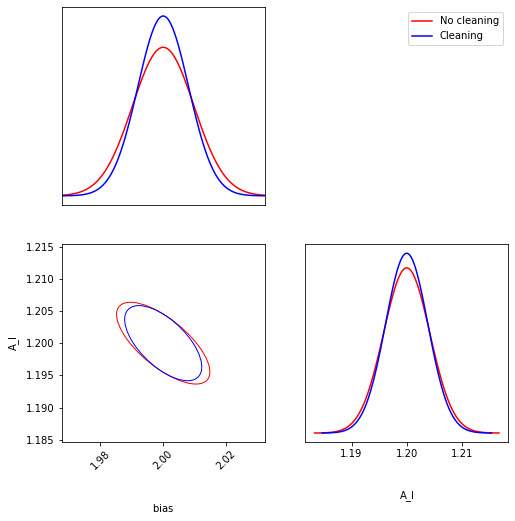

In [29]:
fig, axes = triangle_plot.plot_triangle_base(parameters,fiducial,covlist[2] , one_sigma_only=True,color_1d='red',ellipse_kwargs1={'ls': '-', 'edgecolor': 'red'})
# now plot a slightly cleaned instrument
triangle_plot.plot_triangle_base(parameters,fiducial, covclean[2], one_sigma_only=True,
                                  f=fig, ax=axes,
                                  ellipse_kwargs1={'ls': '-', 'edgecolor': 'blue'},
                                  ellipse_kwargs2={'ls': '-', 'edgecolor': 'blue'},
                                  color_1d='blue'
                                 );

l1, = axes[0, -1].plot([],[],'-',color="red", label='No cleaning')
l2, = axes[0, -1].plot([],[],'-',color="blue", label='Cleaning')
axes[0, -1].legend()
plt.savefig("img201.png")

In [25]:
ells

[2, 102, 202, 302, 402]

In [23]:
ells=[]
for i in range(2,500,100):
    ells.append(i)
plt.plot(ells,100*(base_error-cleaned_error)/cleaned_error,'x-',label='%improvement in cleaning')
plt.legend()

In [30]:
100*(base_error-cleaned_error)/cleaned_error

array([123.24963514,  17.70113008,  11.17936387,   9.13417107,
         8.3714935 ])

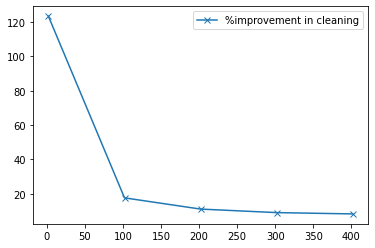

In [24]:
plt.plot(ells,100*(base_error-cleaned_error)/cleaned_error,'x-',label='%improvement in cleaning')
plt.legend()

In [ ]:
## using our built CIB

In [2]:
import numpy as np
from orphics import maps, cosmology,io,stats
import matplotlib.pyplot as plt

from scipy import optimize
import cosmo_cleaner
from cosmo_cleaner import fisher as fisher,plot
import camb
from cosmo_cleaner import cosmology
from cosmo_cleaner import triangle_plot
def get_corr(cross,f1,f2):
    return np.sqrt(cross**2/(f1*f2))
def get_der(spectra,pars,cleaned=False):
    """derivative function used for fisher"""
    der_spectra_alpha = np.ones((len(list(spectra.items())[0][1]), len(spectra), len(pars)))
    for i in range(len(pars)):
        print(f"Taking field derivatives wrt {pars[i]}")
        der=cosmology.derivative_parameter(ells,1,0.5,defaultCosmology,pars[i],delta=0.00005)
        der_spectra_alpha[:, 0, i] = der[1][:cut]
        der_spectra_alpha[:, 1, i] = der[0][:cut]
        if cleaned==True:
            der_spectra_alpha[:, 2, i] = der[-1][:cut]
        else:
            der_spectra_alpha[:, 2, i] = der[2][:cut]
    return der_spectra_alpha


In [3]:
defaultCosmology = {'omch2': 0.1198
                    ,'ombh2': 0.02225
                    ,'H0': 67.3
                    ,'ns': 0.9645
                    ,'As': 2.2e-9
                    ,'mnu': 0.06
                    ,'w0': -1.0
                    ,'tau':0.06
                    ,'nnu':3.046
                    ,'wa': 0.,'bias':2,'A_l':1.2}


nz = 1000
kmax = 10
zmin = 0.
ells=np.arange(2000)

pars = camb.CAMBparams()
pars.set_dark_energy(w=defaultCosmology['w0'],wa = defaultCosmology['wa'], dark_energy_model = 'ppf')
pars.set_cosmology(H0=defaultCosmology['H0'], cosmomc_theta = None,ombh2=defaultCosmology['ombh2'], 
               omch2=defaultCosmology['omch2'], mnu=defaultCosmology['mnu'], tau = defaultCosmology['tau'],
               nnu = defaultCosmology['nnu'], num_massive_neutrinos = 3)
#pars.NonLinear = model.NonLinear_both
pars.InitPower.set_params(ns=defaultCosmology['ns'],As=defaultCosmology['As'])

results = camb.get_results(pars)
default=cosmology.cosmology(nz,kmax,zmin,ells,defaultCosmology,pars,results)

In [5]:
clgg,clkg,clkk,clcibcib,clcibk,cl_clean=default.get_cibspectra(0.1,2)

/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/cosmology.py:86: RuntimeWarning: overflow encountered in exp
  f_nu=lambda x: ((np.exp(h*x/(k*T))-1)**(-1))*x**(beta+3)


clgg


/global/homes/j/jia_qu/.local/lib/python3.7/site-packages/camb/results.py:953: RuntimeWarning: divide by zero encountered in log
  return self.logsign * np.exp(self(z, np.log(kh), grid=grid))
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/cosmology.py:289: RuntimeWarning: invalid value encountered in true_divide
  self.spectra=[clgg,clkg,clkk,clcib,clcibk,clkk-(clcibk**2/clcib)]


Text(0.5, 1.0, 'window function')

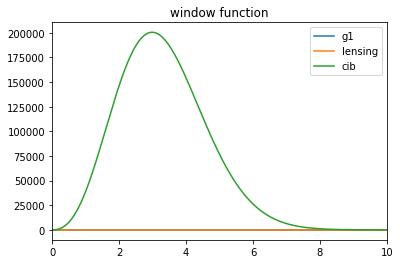

In [6]:
g1=default.windows[0]
g2=default.windows[1]
g3=default.windows[2]
plt.plot(default.zs,g1,label='g1')
plt.plot(default.zs,g2,label='lensing')
plt.plot(default.zs,g3,label='cib')
plt.legend()
plt.xlim(0,10)
plt.title("window function")

In [10]:
cibcl0545=np.loadtxt("/global/homes/j/jia_qu/redshift_cleaning/cibcl0545.txt")[:2000]
import pandas as pd
planck=pd.read_csv("/global/homes/j/jia_qu/cosmo_cleaner/notebooks/planck_cib.csv")


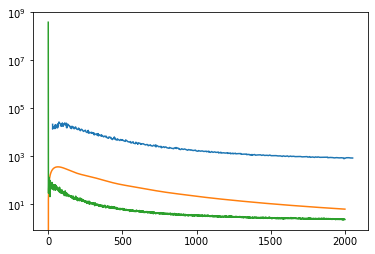

In [45]:
plt.semilogy(planck['bins'],np.array(planck['cls'])*(2.7*10e6)**2)
plt.semilogy(clcibcib*0.01750793)
plt.semilogy(cibcl0545)
#plt.ylim(0)

In [7]:
clkg

array([7.35236344e-07, 7.57602519e-07, 7.51069214e-07, ...,
       4.33542145e-09, 4.33233687e-09, 4.32925600e-09])

/global/homes/j/jia_qu/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Text(0.5, 1.0, 'correlation function')

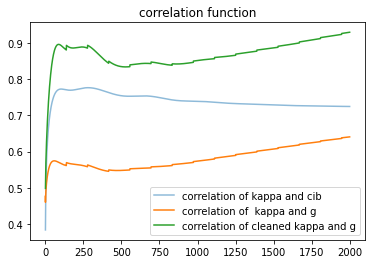

In [6]:
plt.plot(get_corr(clcibk,clcibcib,clkk),label='correlation of kappa and cib',alpha=0.5)
plt.plot(get_corr(clkg,clkk,clgg),label='correlation of  kappa and g')
plt.plot(get_corr(clkg,cl_clean,clgg),label='correlation of cleaned kappa and g')

plt.legend()
plt.title('correlation function')

In [7]:
pars=['bias','A_l']
base_error=[]
fishermatrix=[]
for i in range(2,500,100):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': clkk[:cut]}
    der_spectra_alpha=get_der(spectra,pars,cleaned=False)
    a=fisher.Fisher(1,len(pars),np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    base_error.append(a.get_fisher()[0])
    fishermatrix.append(a.fisher)

2
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:129: RuntimeWarning: divide by zero encountered in true_divide
  return 1/result
/global/u1/j/jia_qu/cosmo_cleaner/cosmo_cleaner/fisher.py:166: RuntimeWarning: divide by zero encountered in power
  self.error_per_mode_non_marginalized = np.nan_to_num(np.diagonal(fisher_per_mode,axis1 = 1, axis2 = 2)**-0.5)


102
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
202
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
302
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
402
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


In [8]:
clean_error=[]
fishermatrix_clean=[]
for i in range(2,500,100):
    print(i)
    cut=i
    spectra = {'kg': clkg[:cut], 'gg' :clgg[:cut], 'kk': cl_clean[:cut]}
    der_spectra_alpha=get_der(spectra,pars,cleaned=True)
    a=fisher.Fisher(1,len(pars),np.arange(len(clkg[:cut])),spectra,der_spectra_alpha)
    clean_error.append(a.get_fisher()[0])
    fishermatrix_clean.append(a.fisher)

2
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
102
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
202
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
302
Taking field derivatives wrt bias
Taking field derivatives wrt A_l
402
Taking field derivatives wrt bias
Taking field derivatives wrt A_l


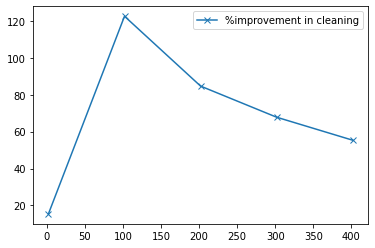

In [10]:
covlist=[]
covclean=[]

base_error=[]
cleaned_error=[]
for i in range(len(fishermatrix_clean)):
    cov=np.linalg.inv(fishermatrix[i])
    cov_clean=np.linalg.inv(fishermatrix_clean[i])
    covlist.append(cov)
    covclean.append(cov_clean)
    error_non_marginalizedbase = np.diag(fishermatrix[i])**-0.5 
    error_non_marginalized = np.diag(fishermatrix_clean[i])**-0.5 
    base_error.append(error_non_marginalizedbase[0])
    cleaned_error.append(error_non_marginalized[0])
cleaned_error=np.array(cleaned_error)
base_error=np.array(base_error)    

parameters=['bias', 'A_l']
fiducial=[2., 1.2]
ells=[]
for i in range(2,500,100):
    ells.append(i)
plt.plot(ells,100*(base_error-cleaned_error)/cleaned_error,'x-',label='%improvement in cleaning')
plt.legend()

generating new axis
['$\\mathrm{bias}$', '$\\mathrm{A\\_l}$']
['$\\mathrm{bias}$', '$\\mathrm{A\\_l}$']


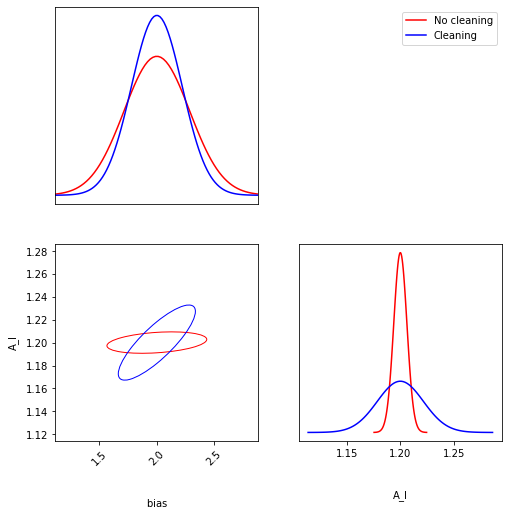

In [12]:
fig, axes = triangle_plot.plot_triangle_base(parameters,fiducial,covlist[1] , one_sigma_only=True,color_1d='red',ellipse_kwargs1={'ls': '-', 'edgecolor': 'red'})
# now plot a slightly cleaned instrument
triangle_plot.plot_triangle_base(parameters,fiducial, covclean[1], one_sigma_only=True,
                                  f=fig, ax=axes,
                                  ellipse_kwargs1={'ls': '-', 'edgecolor': 'blue'},
                                  ellipse_kwargs2={'ls': '-', 'edgecolor': 'blue'},
                                  color_1d='blue'
                                 );

l1, = axes[0, -1].plot([],[],'-',color="red", label='No cleaning')
l2, = axes[0, -1].plot([],[],'-',color="blue", label='Cleaning')
axes[0, -1].legend()
plt.savefig("img400.png")